In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import xpress as xp
xp.init("C:/Users/s2667242/AppData/Local/anaconda3/Lib/site-packages/xpress/license/xpauth.xpr")


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import xpress as xp

# ——— 1. 参数设置 ———
tickers = [
    "AAPL","MSFT","GOOGL","AMZN","META","TSLA","JNJ","JPM","V","PG",
    "NVDA","DIS","UNH","HD","MA","PFE","BAC","KO","XOM","CVX"
]
start_date = "2020-01-01"
end_date   = "2025-07-24"

# ——— 2. 下载价格和成交量数据 ———
data = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=False,
    progress=False
)

# ——— 3. 提取收盘价与成交量（注意：Adj Close 用于收益；Close 用于美元成交额） ———
prices_adj = data["Adj Close"]         # 用于收益
prices_raw = data["Close"]             # 未复权价，用于美元成交额
volumes    = data["Volume"]            # DataFrame (T×d)

# ——— 4. 计算日度简单收益率、平均收益、协方差 ———
returns = prices_adj.pct_change().dropna()   # 用复权价
mean_daily_returns = returns.mean()          # Series, 长度 d
cov_matrix         = returns.cov()           # DataFrame d×d

print("日度平均收益（前5）:")
print(mean_daily_returns.head())
print("\n日度协方差矩阵（前3×3）:")
print(cov_matrix.iloc[:3, :3])

# ——— 5. 日度波动率 σ 与 ADV（逐日美元成交额的均值） ———
# 全样本波动率（用于相关矩阵）
sigma_all  = returns.std(axis=0).values
# 分上下行波动率（用于 γ±）
up_returns   = returns.clip(lower=0)
down_returns = (-returns).clip(lower=0)
sigma_plus   = up_returns.std(axis=0).values
sigma_minus  = down_returns.std(axis=0).values

# ADV：逐日美元成交额（用未复权 Close × Volume），并与 returns 对齐
dollar_vol = (prices_raw.reindex_like(volumes) * volumes).loc[returns.index]
Vbar = dollar_vol.mean(axis=0).values     # shape=(d,)

# ===== 辅助函数：ILLIQ 标定、Gershgorin 上界、delta 反推 =====
def winsorize_ser(s: pd.Series, q=0.995):
    lo, hi = s.quantile(1-q), s.quantile(q)
    return s.clip(lower=lo, upper=hi)

def estimate_kappa_from_illiq(prices_raw: pd.DataFrame,
                              volumes: pd.DataFrame,
                              returns: pd.DataFrame,
                              sigma_vec, side="both"):
    """
    ILLIQ_t = |r_t| / DollarVol_t, DollarVol_t = raw_close_t * volume_t
    κ ≈ median(ILLIQ) * ADV$ / σ
    """
    px_raw = prices_raw.loc[returns.index]
    vol    = volumes.loc[returns.index]
    dollar_vol = (px_raw * vol).replace(0, np.nan)

    illiq = (returns.abs() / dollar_vol).replace([np.inf, -np.inf], np.nan)
    if side == "plus":
        mask = (returns > 0)
    elif side == "minus":
        mask = (returns < 0)
    else:
        mask = pd.DataFrame(True, index=returns.index, columns=returns.columns)

    illiq_med = illiq.where(mask).median(axis=0, skipna=True)
    illiq_med = winsorize_ser(illiq_med, q=0.995)

    # 这里用逐日美元成交额的均值作为 ADV$
    Vbar_local = (px_raw * vol).mean(axis=0)
    sigma = pd.Series(sigma_vec, index=returns.columns)

    kappa = (illiq_med * Vbar_local / sigma).replace([np.inf, -np.inf], np.nan)
    kappa = kappa.clip(lower=0.01, upper=100.0)  # 安全边界
    return kappa.values  # numpy

def gershgorin_delta_max(gamma: np.ndarray, corr: np.ndarray):
    G = np.sqrt(np.outer(gamma, gamma))
    A = np.abs(corr) * G
    row_sum_off = A.sum(axis=1) - np.diag(A)
    row_sum_off = np.where(row_sum_off <= 1e-12, np.inf, row_sum_off)
    return float(np.min(gamma / row_sum_off))

def delta_from_ratio(gamma: np.ndarray, corr: np.ndarray, rho=0.3, cap_ratio=0.9):
    G = np.sqrt(np.outer(gamma, gamma))
    A = np.abs(corr) * G
    row_sum_off = A.sum(axis=1) - np.diag(A)
    factor = row_sum_off / gamma
    mean_factor = np.mean(factor[np.isfinite(factor) & (factor > 0)])
    delta_star = rho / mean_factor if (mean_factor is not None and mean_factor > 0) else 0.0
    delta_max  = gershgorin_delta_max(gamma, corr)
    return float(min(delta_star, cap_ratio * delta_max)), float(delta_max)

# ——— 6. ILLIQ 标定 κ±，并回推 γ±（单位 1/USD） ———
kappa_plus_hat  = estimate_kappa_from_illiq(prices_raw, volumes, returns, sigma_plus,  side="plus")
kappa_minus_hat = estimate_kappa_from_illiq(prices_raw, volumes, returns, sigma_minus, side="minus")

gamma_plus  = kappa_plus_hat  * sigma_plus  / Vbar
gamma_minus = kappa_minus_hat * sigma_minus / Vbar

print("kappa+（前5）:", np.round(kappa_plus_hat[:5], 6))
print("kappa-（前5）:", np.round(kappa_minus_hat[:5], 6))
print("gamma+ 中位数:", np.median(gamma_plus), "  gamma- 中位数:", np.median(gamma_minus))

# ——— 7. 相关系数矩阵 corr（照旧） ———
corr = cov_matrix.values / np.outer(sigma_all, sigma_all)

# ——— 8. 估 δ±（平均 off/diag 比例 + Gershgorin 上界） ———
delta_plus,  delta_plus_max  = delta_from_ratio(gamma_plus,  corr, rho=0.3, cap_ratio=0.9)
delta_minus, delta_minus_max = delta_from_ratio(gamma_minus, corr, rho=0.3, cap_ratio=0.9)
print(f"[delta] +: {delta_plus:.6f} (max {delta_plus_max:.6f}) ; "
      f"-: {delta_minus:.6f} (max {delta_minus_max:.6f})")

# ——— 9. 构造 Ω± 并做统一“bps 标定缩放” ———
Gp = np.sqrt(np.outer(gamma_plus,  gamma_plus))
Gm = np.sqrt(np.outer(gamma_minus, gamma_minus))
Omega_plus  = np.diag(gamma_plus)  + delta_plus  * (Gp * corr)
Omega_minus = np.diag(gamma_minus) + delta_minus * (Gm * corr)

# —— 把“交易 xi% ADV 的成本”校到 target_bps（不改结构，只缩放）——
xi = 0.10         # 10% ADV 的典型交易规模
target_bps = 100   # 目标成本=10 bps，你可调 5~20 看敏感度
c = target_bps / 1e4

s_cand_p = 2*c / np.maximum(gamma_plus  * xi * Vbar, 1e-30)
s_cand_m = 2*c / np.maximum(gamma_minus * xi * Vbar, 1e-30)
s_omega  = float(np.median(np.concatenate([s_cand_p, s_cand_m])))

Omega_plus  = s_omega * Omega_plus
Omega_minus = s_omega * Omega_minus

print(f"[Ω scale] s_omega = {s_omega:.2e}  (xi={xi:.0%}, target={target_bps}bps)")

# —— SPD 体检 —— #
eig_p = np.linalg.eigvalsh(Omega_plus)
eig_m = np.linalg.eigvalsh(Omega_minus)
print("[Ω SPD] min eig + / - :", eig_p.min(), eig_m.min())

# ===== 这里以下继续你原来的 N、budgets、建模求解、可视化代码 =====



日度平均收益（前5）:
Ticker
AAPL    0.000984
AMZN    0.000886
BAC     0.000560
CVX     0.000587
DIS     0.000107
dtype: float64

日度协方差矩阵（前3×3）:
Ticker      AAPL      AMZN       BAC
Ticker                              
AAPL    0.000418  0.000279  0.000197
AMZN    0.000279  0.000514  0.000159
BAC     0.000197  0.000159  0.000495
kappa+（前5）: [0.895103 0.970692 0.859864 0.811191 0.867407]
kappa-（前5）: [0.895397 0.986045 0.824762 0.798705 0.895455]
gamma+ 中位数: 5.7677777587984e-12   gamma- 中位数: 5.5574346561983094e-12
[delta] +: 0.033721 (max 0.049721) ; -: 0.033875 (max 0.048921)
[Ω scale] s_omega = 1.83e+01  (xi=10%, target=100bps)
[Ω SPD] min eig + / - : 1.7493926298221585e-11 1.6385729846363258e-11


In [3]:
# 已有：
# mean_daily_returns : pandas.Series，长度 = 20，对应 20 支股票的日度平均收益
# cov_matrix         : pandas.DataFrame，shape = (20,20)，日度协方差矩阵

N = 10   # 用户数
d = 20
# 1. 期望收益 mu_list
# 转成 NumPy 数组，或 Python 列表
mu_vec = mean_daily_returns.values  # shape = (20,)
mu_list = [mu_vec.copy() for _ in range(N)]

# 2. 协方差矩阵 Sigma_list
Sigma_mat = cov_matrix.values       # shape = (20,20)
Sigma_list = [Sigma_mat.copy() for _ in range(N)]

# 3. （可选）年化处理，如果你需要年化参数：
trading_days = 252
mu_annual   = mu_vec * trading_days          # 年化期望收益
Sigma_annual = Sigma_mat * trading_days      # 年化协方差

mu_list   = [mu_annual.copy() for _ in range(N)]
Sigma_list = [Sigma_annual.copy() for _ in range(N)]



In [4]:
# ——— 3. 风险厌恶系数 γ_k（截断至 [0,1] 的 N(0,1) 采样，seed=42） ———
gamma_list = [
    0.49671415,  # γ₁
    0.64768854,  # γ₂
    0.76743473,  # γ₃
    0.54256004,  # γ₄
    0.24196227,  # γ₅
    0.31424733,  # γ₆
    0.06752820,  # γ₇
    0.11092259,  # γ₈
    0.37569802,  # γ₉
    0.82254491   # γ₁₀
]


In [5]:
# ——— 假设基础数据已定义 ———
# N, d
# mu_list, Sigma_list, gamma_list
# Omega_plus, Omega_minus
budgets = [1e6, 5e5, 8e5, 1.2e6, 6e5, 9e5, 7e5, 4e5, 1.5e6, 1e6]

In [6]:
# === 风险价格 theta_list 标定（使平均|Risk|≈ α × 平均|Revenue|，与求解器目标口径一致）===
alpha = 0.5                     # 你可以取 0.3~0.7 做稳健性
d = len(mu_list[0])
wbar = np.full(d, 1.0/d)        # 基准组合：等权

# 注意：这里用的是“年化”的 mu / Sigma
rev_est = np.array([budgets[n] * (mu_list[n] @ wbar) for n in range(N)])  # USD/年
risk_proto = np.array([
    0.5 * gamma_list[n] * (budgets[n]**2) * (wbar @ Sigma_list[n] @ wbar)  # 正数（不加负号）
    for n in range(N)
])

eps = 1e-12
s = (alpha * max(rev_est.mean(), eps)) / max(risk_proto.mean(), eps)
theta_list = (s * np.array(gamma_list)).tolist()
print(f"[theta] s={s:.3e}; theta in [{min(theta_list):.2e}, {max(theta_list):.2e}] 1/USD/yr")


[theta] s=9.222e-06; theta in [6.23e-07, 7.59e-06] 1/USD/yr


In [7]:

# ——— 全局模型 ———
model = xp.problem()

# 1) 定义所有变量：w[n][j], wp[n][j], wm[n][j]
w  = [[model.addVariable(lb=0.0, ub=budgets[n]) for j in range(d)] for n in range(N)]
wp = [[model.addVariable(lb=0.0, ub=budgets[n]) for j in range(d)] for n in range(N)]
wm = [[model.addVariable(lb=0.0, ub=budgets[n]) for j in range(d)] for n in range(N)]
w_pct = [[model.addVariable(lb=0.0, ub=1.0) for j in range(d)] for n in range(N)]

In [8]:
# ---------- 初始持仓：确定性生成 + 文件缓存（两端脚本都贴这段） ----------
import os, hashlib
import numpy as np
import pandas as pd

INIT_HOLDINGS_PATH = "initial_holdings.csv"  # 两个脚本共用的文件名
INIT_SEED = 12345                             # 你可以改，但两端要一致

def _dirichlet_like_from_hash(tickers, budgets, seed=INIT_SEED):
    """
    用哈希在 (0,1) 上生成独立U，再做 -log(U) 得到 Exp(1)，归一化=Dirichlet(1,...,1)。
    完全确定性：只依赖 (seed, acct_id, ticker)；与全局随机状态无关。
    """
    N = len(budgets); d = len(tickers)
    W = np.zeros((N, d), dtype=float)
    for n in range(N):
        e = np.empty(d, dtype=float)
        for j, t in enumerate(tickers):
            key = f"{seed}|acct={n}|ticker={t}".encode()
            h = hashlib.sha256(key).digest()
            u64 = int.from_bytes(h[:8], "big")
            u = (u64 + 0.5) / 2**64         # map to (0,1)
            u = min(max(u, 1e-12), 1-1e-12) # 保证不开到 0/1
            e[j] = -np.log(u)               # Exp(1)
        w = e / e.sum()
        W[n, :] = w
    B = np.asarray(budgets, dtype=float)[:, None]
    return W * B  # 美元持仓矩阵 (N×d)

def _load_or_make_initial_holdings(tickers, budgets, path=INIT_HOLDINGS_PATH, seed=INIT_SEED):
    if os.path.exists(path):
        df = pd.read_csv(path, index_col=0)
        # 形状/索引检查：若不匹配就重建
        ok_shape = (df.shape[0] == len(budgets)) and (df.shape[1] == len(tickers))
        ok_cols  = list(df.columns) == list(tickers)
        if ok_shape and ok_cols:
            return df.values
        else:
            print(f"[init] 发现旧文件形状或列不符，重新生成并覆盖：{path}")
    # 生成并保存
    arr = _dirichlet_like_from_hash(tickers, budgets, seed=seed)
    df = pd.DataFrame(arr, index=[f"Acct {i}" for i in range(len(budgets))], columns=tickers)
    df.to_csv(path, float_format="%.6f")
    print(f"[init] 已生成初始持仓并写入：{path}")
    return arr

# —— 在两个脚本里都用这一句拿到统一的 old_holdings —— #
old_holdings = _load_or_make_initial_holdings(tickers, budgets)


In [9]:

# 2) 线性化：让 w 变成 new_holdings
for n in range(N):
    for j in range(d):
        # old_holdings[n][j] 已知常数
        model.addConstraint(wp[n][j] - wm[n][j] == w[n][j] - old_holdings[n][j])
        
# ——— 3) 每个账户全仓约束 ∑_j w[n][j] == budgets[n] ———
for n in range(N):
    model.addConstraint(xp.Sum(w[n][j] for j in range(d)) == budgets[n])
    

for n in range(N):
    for j in range(d):
        # w[n][j] = budgets[n] * w_pct[n][j]
        model.addConstraint(w[n][j] == budgets[n] * w_pct[n][j])

# 权重全仓
for n in range(N):
    model.addConstraint(xp.Sum(w_pct[n][j] for j in range(d)) == 1)

# 4) 构造全局交易向量 Wp, Wm （美元）【改】
Wp = [xp.Sum(wp[n][j] for n in range(N)) for j in range(d)]
Wm = [xp.Sum(wm[n][j] for n in range(N)) for j in range(d)]



In [10]:
# ——— 板块股票下标 ———
sector_idxs = {
    "T":  [tickers.index(t) for t in ["AAPL","MSFT","NVDA"]],                          # 信息技术
    "C":  [tickers.index(t) for t in ["GOOGL","META","DIS"]],                          # 内容与娱乐
    "R":  [tickers.index(t) for t in ["AMZN","HD","TSLA"]],                            # 零售与汽车
    "H":  [tickers.index(t) for t in ["JNJ","UNH","PFE"]],                             # 医疗健康
    "F":  [tickers.index(t) for t in ["JPM","BAC","V","MA"]],                          # 金融服务
    "S":  [tickers.index(t) for t in ["PG","KO"]],                                     # 消费必需品
    "E":  [tickers.index(t) for t in ["XOM","CVX"]],                                   # 能源
}
# ——— 3.1) 个性化用户约束 ———
# 用户 0：保守型，消费必需品+医疗 ≥40%，科技+零售 ≤25%
model.addConstraint(xp.Sum(w[0][j] for j in sector_idxs["S"]+sector_idxs["H"]) >=  budgets[0]*0.40)
model.addConstraint(xp.Sum(w[0][j] for j in sector_idxs["T"]+sector_idxs["R"]) <=  budgets[0]*0.25)

# 用户 1：激进成长型，科技 ≥40%，内容+AMZN ≥30%
model.addConstraint(xp.Sum(w[1][j] for j in sector_idxs["T"]) >=  budgets[1]*0.40)
model.addConstraint(xp.Sum(w[1][j] for j in sector_idxs["C"] + [tickers.index("AMZN")]) >=  budgets[1]*.30)

# 用户 2：均衡型，各板块设上下限
model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["T"]) >=  budgets[2]*0.10)
model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["T"]) <= budgets[2]*0.25)
model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["C"]) >= budgets[2]*0.10)
model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["C"]) <= budgets[2]*0.25)
model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["H"]) >= budgets[2]*0.10)
model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["H"]) <= budgets[2]*0.25)
model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["F"]) >= budgets[2]*0.10)
model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["F"]) <= budgets[2]*0.25)
model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["S"]+sector_idxs["E"]) >= budgets[2]*0.05)
model.addConstraint(xp.Sum(w[2][j] for j in sector_idxs["S"]+sector_idxs["E"]) <= budgets[2]*0.15)

# 用户 3：收入型，消费必需+金融+能源 ≥50%，金融 ≥20%
model.addConstraint(xp.Sum(w[3][j] for j in sector_idxs["S"]+sector_idxs["F"]+sector_idxs["E"]) >= budgets[3]*0.50)
model.addConstraint(xp.Sum(w[3][j] for j in sector_idxs["F"]) >= budgets[3]*0.20)

# 用户 4：主题轮动型，能源 ≥15%，金融 ≥25%
model.addConstraint(xp.Sum(w[4][j] for j in sector_idxs["E"]) >= budgets[4]*0.15)
model.addConstraint(xp.Sum(w[4][j] for j in sector_idxs["F"]) >= budgets[4]*0.25)

# 用户 5：科技+医疗，科技 ≥30%，医疗 ≥20%，消费+零售 ≤15%
model.addConstraint(xp.Sum(w[5][j] for j in sector_idxs["T"]) >= budgets[5]*0.30)
model.addConstraint(xp.Sum(w[5][j] for j in sector_idxs["H"]) >= budgets[5]*0.20)
model.addConstraint(xp.Sum(w[5][j] for j in sector_idxs["S"]+sector_idxs["R"]) <= budgets[5]*0.15)

# 用户 6：价值型，成长板块 ≤35%，能源+金融+消费必需 ≥40%
growth6 = sector_idxs["T"] + sector_idxs["C"] + sector_idxs["R"]
model.addConstraint(xp.Sum(w[6][j] for j in growth6) <= budgets[6]*0.35)
model.addConstraint(xp.Sum(w[6][j] for j in sector_idxs["E"]+sector_idxs["F"]+sector_idxs["S"]) >= budgets[6]*0.40)

# 用户 7：小盘偏好（AMZN,TSLA） ≥30%，大盘板块 ≤50%
model.addConstraint(xp.Sum(w[7][j] for j in [tickers.index("AMZN"), tickers.index("TSLA")]) >= budgets[7]*0.30)
model.addConstraint(xp.Sum(w[7][j] for j in sector_idxs["T"]+sector_idxs["F"]+sector_idxs["H"]) <= budgets[7]*0.50)

# 用户 8：高成长偏好 NVDA,TSLA,AAPL,MSFT ≥50%
growth8 = [tickers.index(t) for t in ["NVDA","TSLA","AAPL","MSFT"]]
model.addConstraint(xp.Sum(w[8][j] for j in growth8) >= budgets[8]*0.50)

# 用户 9：防御+成长平衡，防御（S+E） ≥20%，成长（T+C+R） ≥30%
model.addConstraint(xp.Sum(w[9][j] for j in sector_idxs["S"]+sector_idxs["E"]) >= budgets[9]*0.20)
model.addConstraint(xp.Sum(w[9][j] for j in sector_idxs["T"]+sector_idxs["C"]+sector_idxs["R"]) >= budgets[9]*0.30)


In [11]:
# # 假设 budgets[n] 已定义，对应每个账户的最大美元买卖额
# y = [[model.addVariable(vartype=xp.binary) for j in range(d)] for n in range(N)]

# for n in range(N):
#     for j in range(d):
#         # 如果 y[n][j]=1，则可以买，wp[n][j] ≤ budgets[n]; 否则 wp[n][j] ≤ 0
#         model.addConstraint(wp[n][j] <= budgets[n] * y[n][j])
#         # 如果 y[n][j]=0，则可以卖，wm[n][j] ≤ budgets[n]; 否则 wm[n][j] ≤ 0
#         model.addConstraint(wm[n][j] <= budgets[n] * (1 - y[n][j]))


In [12]:
# lin: 年化收益（mu_list 已是年化）
lin = xp.Sum(mu_list[n][j] * w[n][j] for n in range(N) for j in range(d))

# risk: -0.5 * theta_n * (B_n^2) * (w% Σ w%)
risk = xp.Sum(
    -0.5 * theta_list[n] * (budgets[n]**2) *
    xp.Sum(Sigma_list[n][i][j] * w_pct[n][i] * w_pct[n][j] for i in range(d) for j in range(d))
    for n in range(N)
)

# pooled impact（注意：这里是总池成本，不做户级分摊）
Wp = [xp.Sum(wp[n][j] for n in range(N)) for j in range(d)]
Wm = [xp.Sum(wm[n][j] for n in range(N)) for j in range(d)]
cost_p = -0.5 * trading_days * xp.Sum(Omega_plus[i, j]  * Wp[i] * Wp[j] for i in range(d) for j in range(d))
cost_m = -0.5 * trading_days * xp.Sum(Omega_minus[i, j] * Wm[i] * Wm[j] for i in range(d) for j in range(d))

model.setObjective(lin + risk + cost_p + cost_m, sense=xp.maximize)


In [13]:
model.setObjective(lin + risk + cost_p + cost_m, sense=xp.maximize)

# 6) 求解
model.solve()

# 7) 提取结果
solutions = []
for n in range(N):
    w_opt = [model.getSolution(w[n][j]) for j in range(d)]
    solutions.append(w_opt)
    print(f"Account {n} optimal w:", w_opt)


FICO Xpress v9.5.0, Hyper, solve started 1:09:13, Aug 13, 2025
Heap usage: 2006KB (peak 3741KB, 85KB system)
Maximizing QP noname using up to 8 threads and up to 15GB memory, with these control settings:
OUTPUTLOG = 1
NLPPOSTSOLVE = 1
XSLP_DELETIONCONTROL = 0
XSLP_OBJSENSE = -1
Original problem has:
       448 rows          800 cols         1527 elements
     84000 qobjelem
Presolved problem has:
       233 rows          600 cols          910 elements
      8400 qobjelem
Presolve finished in 0 seconds
Heap usage: 3391KB (peak 3741KB, 85KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  1.50e+06] / [ 1.00e+00,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  1.50e+06] / [ 8.24e+01,  1.50e+06]
  Objective      [min,max] : [ 1.31e-02,  7.54e-01] / [ 1.31e-02,  7.54e-01]
  Quadratic      [min,max] : [ 2.47e-11,  3.60e+06] / [ 1.05e-09,  3.50e-06]
Autoscaling applied standard scaling

Using AVX2 support
Core

[CHECK] rebuilt=2,157,709.60 ; model=2,157,709.60 ; Δ=-0.00
✔ 已生成 collusive.csv 与 total_cost.txt（无户级成本分摊）


C:\Users\s2667242\AppData\Local\Temp\ipykernel_43724\1589175747.py:31: DeprecationWarning: Deprecated in Xpress 9.5: use problem.attributes.objval instead
  print(f"[CHECK] rebuilt={obj_rebuilt:,.2f} ; model={model.getObjVal():,.2f} ; Δ={obj_rebuilt - model.getObjVal():,.2f}")


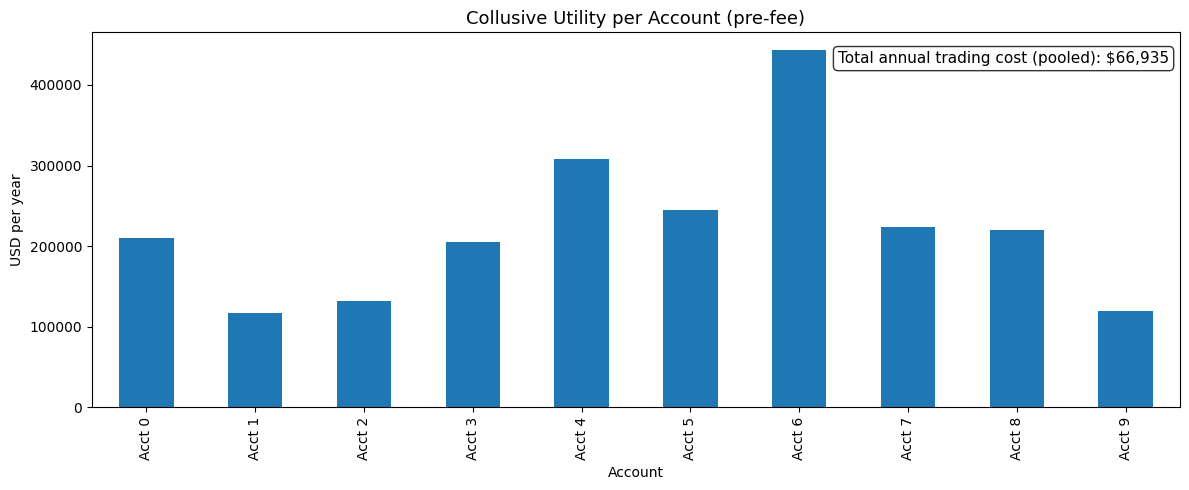

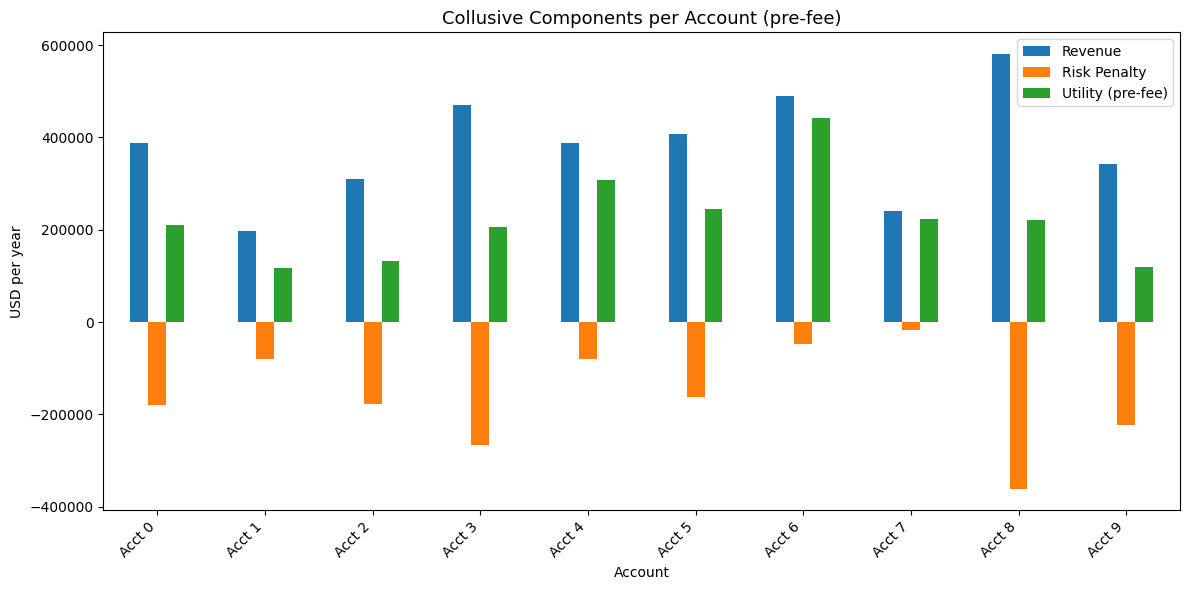

[check dynamic] annualized impact=$66,935 ; T_notional=$11,467,607 ; bps≈58.37


In [14]:
# —— 提取解
solutions = np.zeros((N, d))
wp_vals   = np.zeros((N, d))
wm_vals   = np.zeros((N, d))
for n in range(N):
    for j in range(d):
        solutions[n, j] = model.getSolution(w[n][j])
        wp_vals[n, j]   = model.getSolution(wp[n][j])
        wm_vals[n, j]   = model.getSolution(wm[n][j])

bud_arr = np.array(budgets, dtype=float)
w_pct   = solutions / bud_arr[:, None]
theta   = np.asarray(theta_list, dtype=float)

# —— 每户协同效用（不含成本）：Revenue + RiskPenalty
revenues = np.array([mu_list[n] @ solutions[n] for n in range(N)])  # USD/年
risk_penalty = np.array([
    -0.5 * theta[n] * (bud_arr[n]**2) * (w_pct[n] @ Sigma_list[n] @ w_pct[n])
    for n in range(N)
])
u_col = revenues + risk_penalty

# —— 总年化交易成本（只算一条数）
Wp_tot = wp_vals.sum(axis=0)
Wm_tot = wm_vals.sum(axis=0)
daily_cost  = 0.5 * (Wp_tot @ Omega_plus @ Wp_tot + Wm_tot @ Omega_minus @ Wm_tot)
annual_cost = trading_days * daily_cost

# —— 一致性检查：重构 collusive 目标
obj_rebuilt = u_col.sum() - annual_cost
print(f"[CHECK] rebuilt={obj_rebuilt:,.2f} ; model={model.getObjVal():,.2f} ; Δ={obj_rebuilt - model.getObjVal():,.2f}")

# —— 导出
pd.DataFrame({'u_col': u_col}, index=[f'Acct {i}' for i in range(N)]).to_csv('collusive.csv', float_format='%.6f')
with open('total_cost.txt', 'w') as f:
    f.write(f"{annual_cost:.6f}")
print("✔ 已生成 collusive.csv 与 total_cost.txt（无户级成本分摊）")

# =========================
# 可视化（只画每户收益/风险/u_col + 池化成交结构）
# =========================
# --- English visualization for the collusive solution ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If you just computed these above, they are already in scope:
# u_col (per-account collusive utility before fees), wp_vals, wm_vals,
# Omega_plus, Omega_minus, trading_days, budgets, mu_list, Sigma_list, solutions, theta_list

accounts = [f'Acct {i}' for i in range(len(u_col))]

# Total annual trading cost (single number)
Wp_tot = wp_vals.sum(axis=0)
Wm_tot = wm_vals.sum(axis=0)
daily_cost  = 0.5 * (Wp_tot @ Omega_plus @ Wp_tot + Wm_tot @ Omega_minus @ Wm_tot)
annual_cost = trading_days * daily_cost

# Plot 1: per-account collusive utility (pre-fee)
fig, ax = plt.subplots(figsize=(12, 5))
pd.Series(u_col, index=accounts).plot.bar(ax=ax)
ax.set_title('Collusive Utility per Account (pre-fee)', fontsize=13)
ax.set_ylabel('USD per year')
ax.set_xlabel('Account')

# Annotate total cost once
ax.text(0.99, 0.95,
        f"Total annual trading cost (pooled): ${annual_cost:,.0f}",
        transform=ax.transAxes, ha='right', va='top', fontsize=11,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

# Plot 2: revenue vs. risk penalty vs. net (pre-fee) for each account
revenues = np.array([mu_list[n] @ solutions[n] for n in range(len(budgets))])
bud_arr  = np.asarray(budgets, dtype=float)
w_pct    = solutions / bud_arr[:, None]
theta    = np.asarray(theta_list, dtype=float)
risk_penalty = np.array([
    -0.5 * theta[n] * (bud_arr[n]**2) * (w_pct[n] @ Sigma_list[n] @ w_pct[n])
    for n in range(len(budgets))
])

df_col = pd.DataFrame({
    'Revenue': revenues,
    'Risk Penalty': risk_penalty,
    'Utility (pre-fee)': u_col
}, index=accounts)

ax = df_col.plot.bar(figsize=(12, 6))
ax.set_title('Collusive Components per Account (pre-fee)', fontsize=13)
ax.set_ylabel('USD per year')
ax.set_xlabel('Account')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3) 可选：动态 bps 量级检查（用本次池化名义规模）
T_notional = np.abs(Wp_tot).sum() + np.abs(Wm_tot).sum()
bps_equiv = 1e4 * annual_cost / max(T_notional, 1.0)
print(f"[check dynamic] annualized impact=${annual_cost:,.0f} ; "
      f"T_notional=${T_notional:,.0f} ; bps≈{bps_equiv:.2f}")
